# ECG Classification

Dataset for this project can be downloaded from: https://www.kaggle.com/datasets/khyeh0719/ptb-xl-dataset

Place this notebook in the same folder as the csv files that are contained in the dataset, and change the path as indicated below

## Imports

In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import pandas as pd
import numpy as np
import wfdb
import ast
import IPython.display as ipd
from tqdm import tqdm
import os
from  scipy.io.wavfile  import write as wwrite
from pathlib import Path

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Loads the raw data

In [4]:
# Code here is taken from the PTB_XL paper [1]
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

## Change path to wherever the data is stored

In [5]:
# Code here is taken from the PTB_XL paper [1]
path = 'C:\\Users\\jkill\\CS548\\project\\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1\\'
sampling_rate=500

# Code here is taken from the PTB_XL paper [1]
# load and convert annotation data
Y = pd.read_csv('ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Code here is taken from the PTB_XL paper[1]
# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# load and convert annotation data
Z = pd.read_csv('scp_statements.csv')

In [6]:
# Makes the dictionary to map all the subclasses to their superclasses
mapping = {}
for i in range(0,71):
    mapping.update({Z.iat[i,0]: Z.iat[i,5]})

# Obtains all of the clasifications for each of the records
scp_codes = []
for i in range(0,21837):
    scp_codes.append(Y.iat[i,10])

## Filtering the Records
Each record has a classification ith varying levels of confidence. For this notebook, only the records with 100% confidence are considered. Those that have 100% confidence in multiple classes were also excluded.

In [7]:
# Code for filtering the records by class, with the condition that each record must have a unique 100% accuracy

codes = []
for i in range(0,21837):
    pending = []
    #print(scp_codes[i])
    if(len(scp_codes[i]) == 1):
        tc = list(scp_codes[i].keys())[0]
        value = scp_codes[i][tc]
        if(int(value) == 100):
            codes.append(tc)
            #print("accepted code for this record: ", tc)
            codes[i] = mapping[codes[i]]
        else:
            #print("no 100% code")
            codes.append("n/a")
        #print("code mapped to its superclass: ", codes[i])
    else:
        #print("entering else")
        for x in scp_codes[i]:
            #print("Code: ",x)
            temp = int(scp_codes[i][x])
            #print("temp: ",temp)
            if(temp == 100):
                pending.append(x)
                #print("pending : ",pending)
        if(len(pending) == 1):
            codes.append(pending[0])
            #print("accepted code for this record: ", pending[0])
            codes[i] = mapping[codes[i]]
            #print("code mapped to its superclass: ", codes[i])
        else:
            #print("no 100% code")
            codes.append("n/a")

## Displays the number of records for each class

In [8]:
#Sorts records by class

norm = 0
norm_ecg = []
cd = 0
cd_ecg = []
sttc = 0
sttc_ecg = []
mi = 0
mi_ecg = []
hyp = 0
hyp_ecg = []
na = 0


for i in range(0,len(codes)):
    if(codes[i] == 'NORM'):
        norm += 1
        norm_ecg.append(X[i])
    if(codes[i] == 'CD'):
        cd += 1
        cd_ecg.append(X[i])
    if(codes[i] == 'STTC'):
        sttc += 1
        sttc_ecg.append(X[i])
    if(codes[i] == 'MI'):
        mi += 1
        mi_ecg.append(X[i])
    if(codes[i] == 'HYP'):
        hyp += 1
        hyp_ecg.append(X[i])
    if(codes[i] == 'n/a'):
        na += 1
        
print("The number of NORM records is: ",norm)
print("The number of CD records is: ",cd)
print("The number of STTC records is: ",sttc)
print("The number of MI records is: ",mi)
print("The number of HYP records is: ",hyp)
print("The number of n/a records is: ",na)
norm + cd + sttc + mi + hyp + na

The number of NORM records is:  7036
The number of CD records is:  2142
The number of STTC records is:  2331
The number of MI records is:  1001
The number of HYP records is:  181
The number of n/a records is:  8515


21206

## Creates the folder for the data

In [9]:
current_dir = os.getcwd()
if(os.path.isdir('data')):
    print("Data Exists")
else:
    os.mkdir('data')
folder = "data"
print(f'Data directory will be: {current_dir}/{folder}')

Data Exists
Data directory will be: C:\Users\jkill\CS548\project\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/data


## Normal ECG Example

7036
5000
12


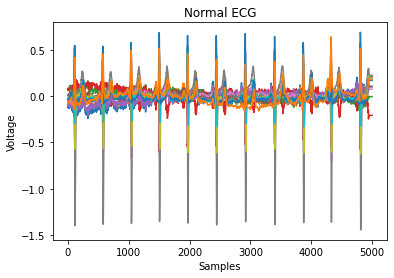

In [10]:
# Normal ECG
print(len(norm_ecg))
print(len(norm_ecg[0]))
print(len(norm_ecg[0][0]))
plt.xlabel('Samples')
plt.ylabel('Voltage')
plt.title('Normal ECG')
plt.plot(norm_ecg[0])

## Conduction Disturbance ECG Example

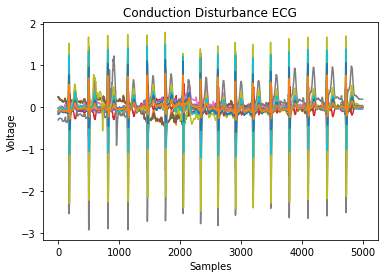

In [11]:
# Conduction Disturbance ECG
plt.xlabel('Samples')
plt.ylabel('Voltage')
plt.title('Conduction Disturbance ECG')
plt.plot(cd_ecg[0])

## ST/T Change ECG Example

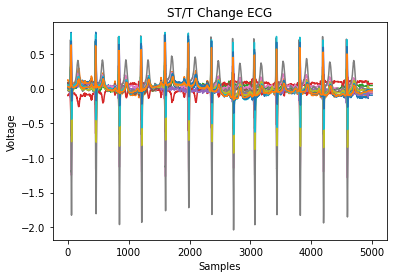

In [12]:
# ST/T Change ECG
plt.xlabel('Samples')
plt.ylabel('Voltage')
plt.title('ST/T Change ECG')
plt.plot(sttc_ecg[0])

## Myocardial Infarction ECG Example

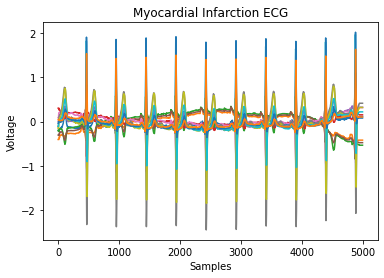

In [13]:
# Myocardial Infarction ECG
plt.xlabel('Samples')
plt.ylabel('Voltage')
plt.title('Myocardial Infarction ECG')
plt.plot(mi_ecg[0])

## Hypertrophy ECG Example

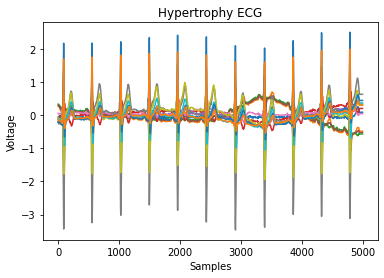

In [14]:
# Hypertrophy ECG
plt.xlabel('Samples')
plt.ylabel('Voltage')
plt.title('Hypertrophy ECG')
plt.plot(hyp_ecg[0])

## Sorts the data into their respective folders

In [15]:
%%time

# Function creates the directories for each of the classes, and loads all of the .wav files into their respective folders
def sort_data(records, label):
    directory = f'./data/waveforms/{label}/'
    if(os.path.isdir(directory)):
        print("Data Exists")
    else:
        os.makedirs(directory, mode=0o777, exist_ok=True)
    
        os.chdir("data")
        os.chdir("waveforms")
        os.chdir(label)
        
        print("sorting ", label, " files")
        for i in range(0,len(records)):
            wwrite(label + str(i) + ".wav", 500, records[i])
    
        os.chdir('..')
        os.chdir('..')
        os.chdir('..')

sort_data(norm_ecg, "NORM")
sort_data(cd_ecg, "CD")
sort_data(sttc_ecg, "STTC")
sort_data(mi_ecg, "MI")
sort_data(hyp_ecg, "HYP")

Data Exists
Data Exists
Data Exists
Data Exists
Data Exists
Wall time: 8.98 ms


## Creating the training and test sets

In [16]:
# Function here is mostly the same as in assignment 4, except the speaker_id and utterance_number are set to 0 since they
# are not relevant to this problem

def load_audio_files(path: str, label:str):

    dataset = []
    
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))

    for i, file_path in enumerate(walker):
        
        path, filename = os.path.split(file_path)
        
        speaker, _ = os.path.splitext(filename)
        
        speaker_id, utterance_number = 0,0    # according to the filenames in the data
        
        utterance_number = int(utterance_number)
        
        waveform, sample_rate = torchaudio.load(file_path)
        
        dataset.append((waveform, sample_rate, label, speaker_id, utterance_number))
        
    return dataset

In [17]:
%%time

#Loads the data from each of the folders into a tensor

labels = ["NORM","CD","STTC","MI","HYP"]
dataset = []
for i in range(0,5):
    print("Loading ",labels[i]," files...")
    dataset.append(load_audio_files('./data/waveforms/' + labels[i], labels[i]))
norm_d = dataset[0]
cd_d = dataset[1]
sttc_d = dataset[2]
mi_d = dataset[3]
hyp_d = dataset[4]

#Function appends the data from each tensor into a single one

def appendData(data,append):
    for i in range(0,len(data)):
        append.append(data[i])
        
#Appends all the data

full_data = []
appendData(norm_d,full_data)
appendData(cd_d,full_data)
appendData(sttc_d,full_data)
appendData(mi_d,full_data)
appendData(hyp_d,full_data)
print("Number of examples: ", len(full_data))

# Shuffle the Data points
np.random.shuffle(full_data)

#90/10 split for Training/Test
trainset = []
testset = []
for i in range(0,11422):
    trainset.append(full_data[i])
for i in range(11422,len(full_data)):
    testset.append(full_data[i])
print("Length of trainset: ",len(trainset))
print("Length of testset:  ",len(testset))

Loading  NORM  files...
Loading  CD  files...
Loading  STTC  files...
Loading  MI  files...
Loading  HYP  files...
Number of examples:  12691
Length of trainset:  11422
Length of testset:   1269
Wall time: 50.5 s


In [18]:
# Left the sample rates the same since training is quick

filename = "./data/waveforms/NORM/NORM0.wav"
waveform, sample_rate = torchaudio.load(filepath=filename)
sample_rate = 500
new_sample_rate = 500
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)

## Following similar process as in class 7 code

In [19]:
# All the functions here are identical to the class 7 code [5]

def label_to_index(word):
    
    # Return the position of the word in labels
    
    return torch.tensor(labels.index(word))


def index_to_label(index):
    
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    
    return labels[index]

def pad_sequence(batch):
    
    # Make all tensor in a batch the same length by padding with zeros
    
    batch = [item.t() for item in batch]
    
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    
    return batch.permute(0, 2, 1)

def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

In [20]:
# Same parameters as in class 7 code [5] checks if there is a gpu

batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

In [21]:
# Taken directly from class 7 code (Pytorch documentation) [5]

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Similar Model as in class 7

Had to change the output dimension, the stride, and the number of channels(since the ECG has 12 leads = 12 channels)

In [22]:
# Same model, seems to get fairly good results without much training [5]

class M5(nn.Module):
    def __init__(self, n_input=1, n_output=5, stride=3, n_channel=12):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=5, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

In [23]:
model = M5(n_input= 12, n_output=len(labels))

model.to(device)

M5(
  (conv1): Conv1d(12, 12, kernel_size=(5,), stride=(3,))
  (bn1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(12, 12, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(12, 24, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(24, 24, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=24, out_features=5, bias=True)
)

In [24]:
print(model)

M5(
  (conv1): Conv1d(12, 12, kernel_size=(5,), stride=(3,))
  (bn1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(12, 12, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(12, 24, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(24, 24, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=24, out_features=5, bias=True)
)


In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
n = count_parameters(model)
print("Number of parameters: %s" % n)

Number of parameters: 4085


In [26]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [27]:
# Code here is identical to class 7 code [5]

def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [28]:
log_interval = 20

n_epoch = 100

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

In [29]:
# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)

In [30]:
%%time

# Same as from code snippets [5]

with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

  0%|                                       | 0.02/100 [00:00<43:12, 25.93s/it]

Train Epoch: 1 [0/11422 (0%)]	Loss: 1.854711


  0%|                         | 0.4200000000000001/100 [00:05<20:55, 12.61s/it]

Train Epoch: 1 [5120/11422 (44%)]	Loss: 0.801678


  1%|▏                        | 0.8200000000000004/100 [00:10<19:47, 11.97s/it]

Train Epoch: 1 [10240/11422 (89%)]	Loss: 0.619988


  1%|▎                        | 1.0000000000000004/100 [00:11<11:41,  7.09s/it]


Test Epoch: 1	Accuracy: 946/1269 (75%)



  1%|▎                        | 1.0200000000000005/100 [00:12<14:13,  8.62s/it]

Train Epoch: 2 [0/11422 (0%)]	Loss: 0.693088


  1%|▎                        | 1.4200000000000008/100 [00:16<19:09, 11.66s/it]

Train Epoch: 2 [5120/11422 (44%)]	Loss: 0.721482


  2%|▍                        | 1.8200000000000012/100 [00:21<18:49, 11.50s/it]

Train Epoch: 2 [10240/11422 (89%)]	Loss: 0.522544


  2%|▌                        | 2.0000000000000013/100 [00:22<11:35,  7.09s/it]


Test Epoch: 2	Accuracy: 967/1269 (76%)



  2%|▌                        | 2.0200000000000014/100 [00:23<14:13,  8.72s/it]

Train Epoch: 3 [0/11422 (0%)]	Loss: 0.497218


  2%|▌                        | 2.4200000000000017/100 [00:28<19:28, 11.98s/it]

Train Epoch: 3 [5120/11422 (44%)]	Loss: 0.629510


  3%|▋                         | 2.820000000000002/100 [00:32<19:03, 11.77s/it]

Train Epoch: 3 [10240/11422 (89%)]	Loss: 0.539689


  3%|▊                        | 3.0200000000000022/100 [00:34<13:48,  8.54s/it]


Test Epoch: 3	Accuracy: 950/1269 (75%)

Train Epoch: 4 [0/11422 (0%)]	Loss: 0.572893


  3%|▊                        | 3.4200000000000026/100 [00:39<18:41, 11.61s/it]

Train Epoch: 4 [5120/11422 (44%)]	Loss: 0.507160


  4%|▉                         | 3.820000000000003/100 [00:43<18:40, 11.65s/it]

Train Epoch: 4 [10240/11422 (89%)]	Loss: 0.572682


  4%|█                         | 4.000000000000003/100 [00:45<11:20,  7.09s/it]


Test Epoch: 4	Accuracy: 954/1269 (75%)



  4%|█                         | 4.020000000000002/100 [00:45<13:36,  8.50s/it]

Train Epoch: 5 [0/11422 (0%)]	Loss: 0.524167


  4%|█▏                        | 4.419999999999994/100 [00:50<18:44, 11.76s/it]

Train Epoch: 5 [5120/11422 (44%)]	Loss: 0.476972


  5%|█▎                        | 4.819999999999985/100 [00:55<18:40, 11.78s/it]

Train Epoch: 5 [10240/11422 (89%)]	Loss: 0.481201


  5%|█▎                        | 4.999999999999981/100 [00:56<11:09,  7.05s/it]


Test Epoch: 5	Accuracy: 983/1269 (77%)



  5%|█▎                        | 5.019999999999981/100 [00:56<13:33,  8.57s/it]

Train Epoch: 6 [0/11422 (0%)]	Loss: 0.591176


  5%|█▍                        | 5.419999999999972/100 [01:01<18:09, 11.52s/it]

Train Epoch: 6 [5120/11422 (44%)]	Loss: 0.507159


  6%|█▌                        | 5.819999999999964/100 [01:06<18:35, 11.84s/it]

Train Epoch: 6 [10240/11422 (89%)]	Loss: 0.646764


  6%|█▌                         | 5.99999999999996/100 [01:07<10:59,  7.02s/it]


Test Epoch: 6	Accuracy: 952/1269 (75%)



  6%|█▋                         | 6.01999999999996/100 [01:07<13:38,  8.71s/it]

Train Epoch: 7 [0/11422 (0%)]	Loss: 0.469903


  6%|█▋                        | 6.419999999999951/100 [01:12<18:36, 11.93s/it]

Train Epoch: 7 [5120/11422 (44%)]	Loss: 0.539236


  7%|█▋                       | 6.8199999999999426/100 [01:17<18:19, 11.80s/it]

Train Epoch: 7 [10240/11422 (89%)]	Loss: 0.694089


  7%|█▊                        | 6.999999999999939/100 [01:18<10:48,  6.98s/it]


Test Epoch: 7	Accuracy: 1003/1269 (79%)



  7%|█▊                        | 7.019999999999938/100 [01:19<13:20,  8.60s/it]

Train Epoch: 8 [0/11422 (0%)]	Loss: 0.528120


  7%|██                         | 7.41999999999993/100 [01:23<17:53, 11.60s/it]

Train Epoch: 8 [5120/11422 (44%)]	Loss: 0.536290


  8%|██                        | 7.819999999999921/100 [01:28<17:44, 11.55s/it]

Train Epoch: 8 [10240/11422 (89%)]	Loss: 0.509935


  8%|██                        | 7.999999999999917/100 [01:30<10:47,  7.04s/it]


Test Epoch: 8	Accuracy: 997/1269 (79%)



  8%|██                        | 8.019999999999918/100 [01:30<13:20,  8.71s/it]

Train Epoch: 9 [0/11422 (0%)]	Loss: 0.466426


  8%|██▎                        | 8.41999999999991/100 [01:34<17:55, 11.74s/it]

Train Epoch: 9 [5120/11422 (44%)]	Loss: 0.506644


  9%|██▍                         | 8.8199999999999/100 [01:39<18:00, 11.85s/it]

Train Epoch: 9 [10240/11422 (89%)]	Loss: 0.461985


  9%|██▎                       | 8.999999999999897/100 [01:41<10:50,  7.15s/it]


Test Epoch: 9	Accuracy: 923/1269 (73%)



  9%|██▎                       | 9.019999999999897/100 [01:41<13:08,  8.66s/it]

Train Epoch: 10 [0/11422 (0%)]	Loss: 0.428633


  9%|██▍                       | 9.419999999999888/100 [01:46<17:44, 11.75s/it]

Train Epoch: 10 [5120/11422 (44%)]	Loss: 0.506846


 10%|██▋                        | 9.81999999999988/100 [01:51<21:31, 14.32s/it]

Train Epoch: 10 [10240/11422 (89%)]	Loss: 0.494775


 10%|██▌                       | 9.999999999999876/100 [01:53<13:33,  9.03s/it]


Test Epoch: 10	Accuracy: 1007/1269 (79%)



 10%|██▌                      | 10.019999999999875/100 [01:53<15:55, 10.61s/it]

Train Epoch: 11 [0/11422 (0%)]	Loss: 0.447689


 10%|██▌                      | 10.419999999999867/100 [01:59<22:02, 14.76s/it]

Train Epoch: 11 [5120/11422 (44%)]	Loss: 0.458553


 11%|██▋                      | 10.819999999999858/100 [02:04<18:22, 12.36s/it]

Train Epoch: 11 [10240/11422 (89%)]	Loss: 0.438018


 11%|██▋                      | 10.999999999999854/100 [02:06<10:44,  7.24s/it]


Test Epoch: 11	Accuracy: 1001/1269 (79%)



 11%|██▊                      | 11.019999999999854/100 [02:06<13:15,  8.94s/it]

Train Epoch: 12 [0/11422 (0%)]	Loss: 0.382169


 11%|██▊                      | 11.419999999999845/100 [02:11<17:12, 11.66s/it]

Train Epoch: 12 [5120/11422 (44%)]	Loss: 0.461088


 12%|██▉                      | 11.819999999999837/100 [02:16<17:49, 12.13s/it]

Train Epoch: 12 [10240/11422 (89%)]	Loss: 0.436329


 12%|██▉                      | 11.999999999999833/100 [02:17<10:03,  6.85s/it]


Test Epoch: 12	Accuracy: 920/1269 (72%)



 12%|███                      | 12.019999999999833/100 [02:18<13:15,  9.04s/it]

Train Epoch: 13 [0/11422 (0%)]	Loss: 0.403713


 12%|███                      | 12.419999999999824/100 [02:23<18:20, 12.57s/it]

Train Epoch: 13 [5120/11422 (44%)]	Loss: 0.353306


 13%|███▏                     | 12.819999999999816/100 [02:28<18:22, 12.65s/it]

Train Epoch: 13 [10240/11422 (89%)]	Loss: 0.338070


 13%|███▏                     | 12.999999999999812/100 [02:30<10:26,  7.20s/it]


Test Epoch: 13	Accuracy: 931/1269 (73%)



 13%|███▎                     | 13.019999999999811/100 [02:30<12:44,  8.79s/it]

Train Epoch: 14 [0/11422 (0%)]	Loss: 0.466054


 13%|███▎                     | 13.419999999999803/100 [02:35<16:55, 11.73s/it]

Train Epoch: 14 [5120/11422 (44%)]	Loss: 0.500033


 14%|███▍                     | 13.819999999999794/100 [02:39<16:43, 11.64s/it]

Train Epoch: 14 [10240/11422 (89%)]	Loss: 0.525845


 14%|███▋                      | 13.99999999999979/100 [02:41<10:08,  7.07s/it]


Test Epoch: 14	Accuracy: 1003/1269 (79%)



 14%|███▋                      | 14.01999999999979/100 [02:41<12:21,  8.63s/it]

Train Epoch: 15 [0/11422 (0%)]	Loss: 0.414084


 14%|███▌                     | 14.419999999999781/100 [02:46<16:29, 11.57s/it]

Train Epoch: 15 [5120/11422 (44%)]	Loss: 0.515669


 15%|███▋                     | 14.819999999999773/100 [02:50<16:40, 11.74s/it]

Train Epoch: 15 [10240/11422 (89%)]	Loss: 0.433301


 15%|███▋                     | 14.999999999999769/100 [02:52<10:14,  7.23s/it]


Test Epoch: 15	Accuracy: 987/1269 (78%)



 15%|███▊                     | 15.019999999999769/100 [02:52<12:30,  8.83s/it]

Train Epoch: 16 [0/11422 (0%)]	Loss: 0.449231


 15%|████                      | 15.41999999999976/100 [02:57<16:31, 11.72s/it]

Train Epoch: 16 [5120/11422 (44%)]	Loss: 0.377794


 16%|███▉                     | 15.819999999999752/100 [03:02<16:02, 11.44s/it]

Train Epoch: 16 [10240/11422 (89%)]	Loss: 0.369059


 16%|███▉                     | 15.999999999999748/100 [03:03<09:55,  7.09s/it]


Test Epoch: 16	Accuracy: 1005/1269 (79%)



 16%|████                     | 16.019999999999747/100 [03:03<12:03,  8.62s/it]

Train Epoch: 17 [0/11422 (0%)]	Loss: 0.405281


 16%|████▎                     | 16.41999999999974/100 [03:08<16:29, 11.84s/it]

Train Epoch: 17 [5120/11422 (44%)]	Loss: 0.421857


 17%|████▎                     | 16.81999999999973/100 [03:13<16:29, 11.89s/it]

Train Epoch: 17 [10240/11422 (89%)]	Loss: 0.427886


 17%|████▏                    | 16.999999999999726/100 [03:14<09:42,  7.02s/it]


Test Epoch: 17	Accuracy: 1012/1269 (80%)



 17%|████▎                    | 17.019999999999726/100 [03:14<11:53,  8.60s/it]

Train Epoch: 18 [0/11422 (0%)]	Loss: 0.464196


 17%|████▎                    | 17.419999999999717/100 [03:19<16:02, 11.65s/it]

Train Epoch: 18 [5120/11422 (44%)]	Loss: 0.459595


 18%|████▋                     | 17.81999999999971/100 [03:24<16:00, 11.69s/it]

Train Epoch: 18 [10240/11422 (89%)]	Loss: 0.357973


 18%|████▍                    | 17.999999999999705/100 [03:25<09:22,  6.86s/it]


Test Epoch: 18	Accuracy: 1016/1269 (80%)



 18%|████▌                    | 18.019999999999705/100 [03:25<11:29,  8.42s/it]

Train Epoch: 19 [0/11422 (0%)]	Loss: 0.501599


 18%|████▌                    | 18.419999999999696/100 [03:30<16:16, 11.97s/it]

Train Epoch: 19 [5120/11422 (44%)]	Loss: 0.420288


 19%|████▋                    | 18.819999999999688/100 [03:35<15:47, 11.68s/it]

Train Epoch: 19 [10240/11422 (89%)]	Loss: 0.411357


 19%|████▋                    | 18.999999999999684/100 [03:37<09:36,  7.11s/it]


Test Epoch: 19	Accuracy: 991/1269 (78%)



 19%|████▊                    | 19.019999999999683/100 [03:37<12:02,  8.92s/it]

Train Epoch: 20 [0/11422 (0%)]	Loss: 0.374667


 19%|████▊                    | 19.419999999999675/100 [03:41<15:28, 11.52s/it]

Train Epoch: 20 [5120/11422 (44%)]	Loss: 0.506836


 20%|████▉                    | 19.819999999999666/100 [03:46<15:20, 11.49s/it]

Train Epoch: 20 [10240/11422 (89%)]	Loss: 0.455064


 20%|████▉                    | 19.999999999999662/100 [03:48<09:26,  7.08s/it]


Test Epoch: 20	Accuracy: 1020/1269 (80%)



 20%|█████                    | 20.019999999999662/100 [03:48<11:25,  8.57s/it]

Train Epoch: 21 [0/11422 (0%)]	Loss: 0.404914


 20%|█████                    | 20.419999999999654/100 [03:53<15:24, 11.62s/it]

Train Epoch: 21 [5120/11422 (44%)]	Loss: 0.526874


 21%|█████▏                   | 20.819999999999645/100 [03:57<15:25, 11.68s/it]

Train Epoch: 21 [10240/11422 (89%)]	Loss: 0.360290


 21%|█████▍                    | 20.99999999999964/100 [03:59<09:20,  7.09s/it]


Test Epoch: 21	Accuracy: 1022/1269 (81%)



 21%|█████▍                    | 21.01999999999964/100 [03:59<11:33,  8.78s/it]

Train Epoch: 22 [0/11422 (0%)]	Loss: 0.403363


 21%|█████▎                   | 21.419999999999632/100 [04:04<15:27, 11.80s/it]

Train Epoch: 22 [5120/11422 (44%)]	Loss: 0.388662


 22%|█████▍                   | 21.819999999999624/100 [04:08<15:15, 11.71s/it]

Train Epoch: 22 [10240/11422 (89%)]	Loss: 0.374806


 22%|█████▋                    | 21.99999999999962/100 [04:10<09:06,  7.01s/it]


Test Epoch: 22	Accuracy: 1028/1269 (81%)



 22%|█████▋                    | 22.01999999999962/100 [04:10<11:08,  8.57s/it]

Train Epoch: 23 [0/11422 (0%)]	Loss: 0.346202


 22%|█████▊                    | 22.41999999999961/100 [04:15<15:20, 11.86s/it]

Train Epoch: 23 [5120/11422 (44%)]	Loss: 0.358952


 23%|█████▋                   | 22.819999999999602/100 [04:20<15:18, 11.91s/it]

Train Epoch: 23 [10240/11422 (89%)]	Loss: 0.336490


 23%|██████▏                    | 22.9999999999996/100 [04:21<09:11,  7.16s/it]


Test Epoch: 23	Accuracy: 1030/1269 (81%)



 23%|█████▊                   | 23.019999999999598/100 [04:21<10:53,  8.49s/it]

Train Epoch: 24 [0/11422 (0%)]	Loss: 0.343229


 23%|██████                    | 23.41999999999959/100 [04:26<15:16, 11.96s/it]

Train Epoch: 24 [5120/11422 (44%)]	Loss: 0.353912


 24%|██████▏                   | 23.81999999999958/100 [04:31<14:44, 11.61s/it]

Train Epoch: 24 [10240/11422 (89%)]	Loss: 0.315829


 24%|█████▉                   | 23.999999999999577/100 [04:32<08:37,  6.81s/it]


Test Epoch: 24	Accuracy: 1027/1269 (81%)



 24%|██████                   | 24.019999999999577/100 [04:32<10:53,  8.61s/it]

Train Epoch: 25 [0/11422 (0%)]	Loss: 0.339595


 24%|██████▎                   | 24.41999999999957/100 [04:37<14:46, 11.73s/it]

Train Epoch: 25 [5120/11422 (44%)]	Loss: 0.401861


 25%|██████▍                   | 24.81999999999956/100 [04:42<14:36, 11.66s/it]

Train Epoch: 25 [10240/11422 (89%)]	Loss: 0.347460


 25%|██████▏                  | 24.999999999999556/100 [04:43<08:39,  6.93s/it]


Test Epoch: 25	Accuracy: 1025/1269 (81%)



 25%|██████▎                  | 25.019999999999555/100 [04:44<10:34,  8.47s/it]

Train Epoch: 26 [0/11422 (0%)]	Loss: 0.370635


 25%|██████▎                  | 25.419999999999547/100 [04:48<14:41, 11.82s/it]

Train Epoch: 26 [5120/11422 (44%)]	Loss: 0.458195


 26%|██████▋                   | 25.81999999999954/100 [04:53<14:18, 11.58s/it]

Train Epoch: 26 [10240/11422 (89%)]	Loss: 0.463796


 26%|██████▍                  | 25.999999999999535/100 [04:54<08:40,  7.03s/it]


Test Epoch: 26	Accuracy: 1035/1269 (82%)



 26%|██████▌                  | 26.019999999999534/100 [04:55<10:40,  8.66s/it]

Train Epoch: 27 [0/11422 (0%)]	Loss: 0.314824


 26%|██████▌                  | 26.419999999999526/100 [04:59<14:06, 11.51s/it]

Train Epoch: 27 [5120/11422 (44%)]	Loss: 0.341682


 27%|██████▋                  | 26.819999999999517/100 [05:04<14:01, 11.50s/it]

Train Epoch: 27 [10240/11422 (89%)]	Loss: 0.355582


 27%|██████▋                  | 26.999999999999513/100 [05:06<08:33,  7.04s/it]


Test Epoch: 27	Accuracy: 1028/1269 (81%)



 27%|██████▊                  | 27.019999999999513/100 [05:06<10:33,  8.68s/it]

Train Epoch: 28 [0/11422 (0%)]	Loss: 0.404105


 27%|██████▊                  | 27.419999999999504/100 [05:11<14:11, 11.74s/it]

Train Epoch: 28 [5120/11422 (44%)]	Loss: 0.454782


 28%|██████▉                  | 27.819999999999496/100 [05:15<13:44, 11.42s/it]

Train Epoch: 28 [10240/11422 (89%)]	Loss: 0.431553


 28%|██████▉                  | 27.999999999999492/100 [05:17<08:22,  6.98s/it]


Test Epoch: 28	Accuracy: 1041/1269 (82%)



 28%|███████▎                  | 28.01999999999949/100 [05:17<10:31,  8.77s/it]

Train Epoch: 29 [0/11422 (0%)]	Loss: 0.399009


 28%|███████                  | 28.419999999999483/100 [05:22<14:33, 12.21s/it]

Train Epoch: 29 [5120/11422 (44%)]	Loss: 0.393664


 29%|███████▏                 | 28.819999999999474/100 [05:27<14:01, 11.82s/it]

Train Epoch: 29 [10240/11422 (89%)]	Loss: 0.424916


 29%|███████▌                  | 28.99999999999947/100 [05:28<08:19,  7.04s/it]


Test Epoch: 29	Accuracy: 1018/1269 (80%)



 29%|███████▌                  | 29.01999999999947/100 [05:28<10:10,  8.60s/it]

Train Epoch: 30 [0/11422 (0%)]	Loss: 0.421113


 29%|███████▋                  | 29.41999999999946/100 [05:33<13:26, 11.43s/it]

Train Epoch: 30 [5120/11422 (44%)]	Loss: 0.313275


 30%|███████▍                 | 29.819999999999453/100 [05:38<13:40, 11.69s/it]

Train Epoch: 30 [10240/11422 (89%)]	Loss: 0.348222


 30%|███████▊                  | 29.99999999999945/100 [05:39<08:12,  7.04s/it]


Test Epoch: 30	Accuracy: 1024/1269 (81%)



 30%|███████▊                  | 30.01999999999945/100 [05:39<10:01,  8.60s/it]

Train Epoch: 31 [0/11422 (0%)]	Loss: 0.343230


 30%|███████▉                  | 30.41999999999944/100 [05:44<13:35, 11.72s/it]

Train Epoch: 31 [5120/11422 (44%)]	Loss: 0.339623


 31%|███████▋                 | 30.819999999999432/100 [05:49<13:43, 11.91s/it]

Train Epoch: 31 [10240/11422 (89%)]	Loss: 0.282357


 31%|███████▋                 | 30.999999999999428/100 [05:50<08:05,  7.04s/it]


Test Epoch: 31	Accuracy: 1032/1269 (81%)



 31%|███████▊                 | 31.019999999999428/100 [05:51<09:56,  8.65s/it]

Train Epoch: 32 [0/11422 (0%)]	Loss: 0.378247


 31%|████████▏                 | 31.41999999999942/100 [05:55<13:30, 11.82s/it]

Train Epoch: 32 [5120/11422 (44%)]	Loss: 0.355526


 32%|████████▎                 | 31.81999999999941/100 [06:03<29:30, 25.98s/it]

Train Epoch: 32 [10240/11422 (89%)]	Loss: 0.307662


 32%|███████▉                 | 31.999999999999407/100 [06:06<14:41, 12.97s/it]


Test Epoch: 32	Accuracy: 1024/1269 (81%)



 32%|████████                 | 32.019999999999406/100 [06:06<17:08, 15.12s/it]

Train Epoch: 33 [0/11422 (0%)]	Loss: 0.354172


 32%|████████▍                 | 32.41999999999947/100 [06:14<20:03, 17.81s/it]

Train Epoch: 33 [5120/11422 (44%)]	Loss: 0.296246


 33%|████████▌                 | 32.81999999999953/100 [06:21<19:55, 17.80s/it]

Train Epoch: 33 [10240/11422 (89%)]	Loss: 0.323825


 33%|████████▌                 | 32.99999999999956/100 [06:23<13:35, 12.17s/it]


Test Epoch: 33	Accuracy: 1032/1269 (81%)



 33%|████████▌                 | 33.01999999999956/100 [06:24<15:47, 14.15s/it]

Train Epoch: 34 [0/11422 (0%)]	Loss: 0.350752


 33%|████████▎                | 33.419999999999625/100 [06:31<19:12, 17.31s/it]

Train Epoch: 34 [5120/11422 (44%)]	Loss: 0.436202


 34%|████████▊                 | 33.81999999999969/100 [06:37<15:47, 14.32s/it]

Train Epoch: 34 [10240/11422 (89%)]	Loss: 0.398896


 34%|████████▍                | 33.999999999999716/100 [06:39<09:41,  8.80s/it]


Test Epoch: 34	Accuracy: 1024/1269 (81%)



 34%|████████▊                 | 34.01999999999972/100 [06:39<11:35, 10.54s/it]

Train Epoch: 35 [0/11422 (0%)]	Loss: 0.351618


 34%|████████▉                 | 34.41999999999978/100 [06:45<14:33, 13.33s/it]

Train Epoch: 35 [5120/11422 (44%)]	Loss: 0.303890


 35%|████████▋                | 34.819999999999844/100 [06:50<14:23, 13.25s/it]

Train Epoch: 35 [10240/11422 (89%)]	Loss: 0.405446


 35%|█████████                 | 34.99999999999987/100 [06:52<07:56,  7.33s/it]


Test Epoch: 35	Accuracy: 1029/1269 (81%)



 35%|████████▊                | 35.019999999999875/100 [06:52<09:28,  8.75s/it]

Train Epoch: 36 [0/11422 (0%)]	Loss: 0.328172


 35%|█████████▏                | 35.41999999999994/100 [06:57<13:03, 12.14s/it]

Train Epoch: 36 [5120/11422 (44%)]	Loss: 0.325517


 36%|█████████████▌                        | 35.82/100 [07:02<14:40, 13.72s/it]

Train Epoch: 36 [10240/11422 (89%)]	Loss: 0.300557


 36%|█████████▎                | 36.00000000000003/100 [07:04<08:52,  8.33s/it]


Test Epoch: 36	Accuracy: 1032/1269 (81%)



 36%|█████████▎                | 36.02000000000003/100 [07:04<10:45, 10.09s/it]

Train Epoch: 37 [0/11422 (0%)]	Loss: 0.390222


 36%|█████████                | 36.420000000000094/100 [07:10<15:53, 14.99s/it]

Train Epoch: 37 [5120/11422 (44%)]	Loss: 0.350633


 37%|█████████▌                | 36.82000000000016/100 [07:15<12:34, 11.93s/it]

Train Epoch: 37 [10240/11422 (89%)]	Loss: 0.322628


 37%|█████████▎               | 37.000000000000185/100 [07:17<07:28,  7.13s/it]


Test Epoch: 37	Accuracy: 1029/1269 (81%)



 37%|█████████▋                | 37.02000000000019/100 [07:17<09:08,  8.71s/it]

Train Epoch: 38 [0/11422 (0%)]	Loss: 0.301101


 37%|█████████▋                | 37.42000000000025/100 [07:22<14:26, 13.85s/it]

Train Epoch: 38 [5120/11422 (44%)]	Loss: 0.366754


 38%|█████████▊                | 37.82000000000031/100 [07:28<12:47, 12.34s/it]

Train Epoch: 38 [10240/11422 (89%)]	Loss: 0.312263


 38%|█████████▉                | 38.00000000000034/100 [07:29<07:27,  7.22s/it]


Test Epoch: 38	Accuracy: 1032/1269 (81%)



 38%|█████████▌               | 38.020000000000344/100 [07:29<09:07,  8.83s/it]

Train Epoch: 39 [0/11422 (0%)]	Loss: 0.368391


 38%|█████████▉                | 38.42000000000041/100 [07:34<12:15, 11.95s/it]

Train Epoch: 39 [5120/11422 (44%)]	Loss: 0.325620


 39%|██████████                | 38.82000000000047/100 [07:39<12:18, 12.07s/it]

Train Epoch: 39 [10240/11422 (89%)]	Loss: 0.318845


 39%|██████████▌                | 39.0000000000005/100 [07:41<07:12,  7.09s/it]


Test Epoch: 39	Accuracy: 1021/1269 (80%)



 39%|██████████▌                | 39.0200000000005/100 [07:41<09:11,  9.04s/it]

Train Epoch: 40 [0/11422 (0%)]	Loss: 0.327082


 39%|██████████▏               | 39.42000000000056/100 [07:46<12:21, 12.24s/it]

Train Epoch: 40 [5120/11422 (44%)]	Loss: 0.450935


 40%|█████████▉               | 39.820000000000626/100 [07:51<12:11, 12.15s/it]

Train Epoch: 40 [10240/11422 (89%)]	Loss: 0.308399


 40%|██████████               | 40.000000000000654/100 [07:52<07:06,  7.10s/it]


Test Epoch: 40	Accuracy: 1020/1269 (80%)



 40%|██████████▍               | 40.02000000000066/100 [07:52<08:49,  8.83s/it]

Train Epoch: 41 [0/11422 (0%)]	Loss: 0.362889


 40%|██████████▌               | 40.42000000000072/100 [07:57<11:56, 12.03s/it]

Train Epoch: 41 [5120/11422 (44%)]	Loss: 0.318230


 41%|██████████▌               | 40.82000000000078/100 [08:02<12:10, 12.34s/it]

Train Epoch: 41 [10240/11422 (89%)]	Loss: 0.386505


 41%|██████████▋               | 41.00000000000081/100 [08:03<07:01,  7.14s/it]


Test Epoch: 41	Accuracy: 1031/1269 (81%)



 41%|██████████▋               | 41.02000000000081/100 [08:04<08:41,  8.84s/it]

Train Epoch: 42 [0/11422 (0%)]	Loss: 0.366854


 41%|██████████▎              | 41.420000000000876/100 [08:09<12:01, 12.32s/it]

Train Epoch: 42 [5120/11422 (44%)]	Loss: 0.329181


 42%|██████████▊               | 41.82000000000094/100 [08:13<11:49, 12.19s/it]

Train Epoch: 42 [10240/11422 (89%)]	Loss: 0.318349


 42%|██████████▌              | 42.000000000000966/100 [08:15<07:09,  7.40s/it]


Test Epoch: 42	Accuracy: 1030/1269 (81%)



 42%|██████████▉               | 42.02000000000097/100 [08:15<08:31,  8.82s/it]

Train Epoch: 43 [0/11422 (0%)]	Loss: 0.334237


 42%|███████████               | 42.42000000000103/100 [08:20<11:34, 12.05s/it]

Train Epoch: 43 [5120/11422 (44%)]	Loss: 0.357673


 43%|██████████▋              | 42.820000000001095/100 [08:25<11:09, 11.72s/it]

Train Epoch: 43 [10240/11422 (89%)]	Loss: 0.434735


 43%|███████████▏              | 43.00000000000112/100 [08:26<06:58,  7.34s/it]


Test Epoch: 43	Accuracy: 1026/1269 (81%)



 43%|██████████▊              | 43.020000000001126/100 [08:27<08:36,  9.06s/it]

Train Epoch: 44 [0/11422 (0%)]	Loss: 0.281098


 43%|███████████▎              | 43.42000000000119/100 [08:32<12:09, 12.90s/it]

Train Epoch: 44 [5120/11422 (44%)]	Loss: 0.331436


 44%|███████████▍              | 43.82000000000125/100 [08:36<11:30, 12.29s/it]

Train Epoch: 44 [10240/11422 (89%)]	Loss: 0.280595


 44%|███████████▍              | 44.00000000000128/100 [08:38<06:44,  7.22s/it]


Test Epoch: 44	Accuracy: 1028/1269 (81%)



 44%|███████████▍              | 44.02000000000128/100 [08:38<08:20,  8.93s/it]

Train Epoch: 45 [0/11422 (0%)]	Loss: 0.322847


 44%|███████████              | 44.420000000001345/100 [08:43<11:01, 11.90s/it]

Train Epoch: 45 [5120/11422 (44%)]	Loss: 0.360935


 45%|███████████▋              | 44.82000000000141/100 [08:48<11:06, 12.07s/it]

Train Epoch: 45 [10240/11422 (89%)]	Loss: 0.379334


 45%|███████████▎             | 45.000000000001435/100 [08:50<06:50,  7.46s/it]


Test Epoch: 45	Accuracy: 1028/1269 (81%)



 45%|███████████▋              | 45.02000000000144/100 [08:50<08:19,  9.09s/it]

Train Epoch: 46 [0/11422 (0%)]	Loss: 0.287326


 45%|████████████▎              | 45.4200000000015/100 [08:55<10:57, 12.05s/it]

Train Epoch: 46 [5120/11422 (44%)]	Loss: 0.341423


 46%|███████████▉              | 45.82000000000156/100 [09:00<10:54, 12.08s/it]

Train Epoch: 46 [10240/11422 (89%)]	Loss: 0.269988


 46%|███████████▉              | 46.00000000000159/100 [09:01<06:28,  7.20s/it]


Test Epoch: 46	Accuracy: 1026/1269 (81%)



 46%|███████████▌             | 46.020000000001595/100 [09:01<08:00,  8.90s/it]

Train Epoch: 47 [0/11422 (0%)]	Loss: 0.408495


 46%|████████████              | 46.42000000000166/100 [09:06<11:07, 12.46s/it]

Train Epoch: 47 [5120/11422 (44%)]	Loss: 0.278769


 47%|████████████▏             | 46.82000000000172/100 [09:11<10:55, 12.32s/it]

Train Epoch: 47 [10240/11422 (89%)]	Loss: 0.433526


 47%|████████████▏             | 47.00000000000175/100 [09:13<06:22,  7.22s/it]


Test Epoch: 47	Accuracy: 1030/1269 (81%)



 47%|████████████▏             | 47.02000000000175/100 [09:13<07:35,  8.61s/it]

Train Epoch: 48 [0/11422 (0%)]	Loss: 0.378382


 47%|███████████▊             | 47.420000000001814/100 [09:18<11:14, 12.84s/it]

Train Epoch: 48 [5120/11422 (44%)]	Loss: 0.290122


 48%|███████████▉             | 47.820000000001876/100 [09:23<10:44, 12.35s/it]

Train Epoch: 48 [10240/11422 (89%)]	Loss: 0.292110


 48%|████████████             | 48.000000000001904/100 [09:24<06:24,  7.40s/it]


Test Epoch: 48	Accuracy: 1027/1269 (81%)



 48%|████████████▍             | 48.02000000000191/100 [09:25<07:41,  8.88s/it]

Train Epoch: 49 [0/11422 (0%)]	Loss: 0.316229


 48%|████████████▌             | 48.42000000000197/100 [09:29<10:05, 11.74s/it]

Train Epoch: 49 [5120/11422 (44%)]	Loss: 0.381518


 49%|████████████▋             | 48.82000000000203/100 [09:35<11:58, 14.04s/it]

Train Epoch: 49 [10240/11422 (89%)]	Loss: 0.333604


 49%|████████████▋             | 49.00000000000206/100 [09:37<07:01,  8.26s/it]


Test Epoch: 49	Accuracy: 1025/1269 (81%)



 49%|████████████▎            | 49.020000000002064/100 [09:37<08:34, 10.09s/it]

Train Epoch: 50 [0/11422 (0%)]	Loss: 0.274845


 49%|████████████▎            | 49.420000000002126/100 [09:42<10:14, 12.15s/it]

Train Epoch: 50 [5120/11422 (44%)]	Loss: 0.322285


 50%|████████████▉             | 49.82000000000219/100 [09:47<11:57, 14.30s/it]

Train Epoch: 50 [10240/11422 (89%)]	Loss: 0.395420


 50%|█████████████             | 50.00000000000222/100 [09:49<06:43,  8.07s/it]


Test Epoch: 50	Accuracy: 1027/1269 (81%)



 50%|█████████████             | 50.02000000000222/100 [09:49<08:00,  9.61s/it]

Train Epoch: 51 [0/11422 (0%)]	Loss: 0.435256


 50%|█████████████             | 50.42000000000228/100 [09:54<10:10, 12.31s/it]

Train Epoch: 51 [5120/11422 (44%)]	Loss: 0.282042


 51%|████████████▋            | 50.820000000002345/100 [09:59<09:57, 12.14s/it]

Train Epoch: 51 [10240/11422 (89%)]	Loss: 0.419774


 51%|█████████████▎            | 51.00000000000237/100 [10:01<06:03,  7.42s/it]


Test Epoch: 51	Accuracy: 1028/1269 (81%)



 51%|████████████▊            | 51.020000000002376/100 [10:01<07:22,  9.04s/it]

Train Epoch: 52 [0/11422 (0%)]	Loss: 0.366848


 51%|█████████████▎            | 51.42000000000244/100 [10:06<09:55, 12.27s/it]

Train Epoch: 52 [5120/11422 (44%)]	Loss: 0.364694


 52%|█████████████▉             | 51.8200000000025/100 [10:11<09:29, 11.81s/it]

Train Epoch: 52 [10240/11422 (89%)]	Loss: 0.435248


 52%|█████████████▌            | 52.00000000000253/100 [10:12<05:37,  7.04s/it]


Test Epoch: 52	Accuracy: 1028/1269 (81%)



 52%|█████████████▌            | 52.02000000000253/100 [10:12<06:57,  8.71s/it]

Train Epoch: 53 [0/11422 (0%)]	Loss: 0.342880


 52%|█████████████            | 52.420000000002595/100 [10:17<09:33, 12.04s/it]

Train Epoch: 53 [5120/11422 (44%)]	Loss: 0.339743


 53%|█████████████▋            | 52.82000000000266/100 [10:22<09:38, 12.25s/it]

Train Epoch: 53 [10240/11422 (89%)]	Loss: 0.283090


 53%|█████████████▎           | 53.000000000002686/100 [10:24<05:59,  7.65s/it]


Test Epoch: 53	Accuracy: 1029/1269 (81%)



 53%|█████████████▊            | 53.02000000000269/100 [10:24<07:17,  9.32s/it]

Train Epoch: 54 [0/11422 (0%)]	Loss: 0.375476


 53%|█████████████▉            | 53.42000000000275/100 [10:29<10:11, 13.13s/it]

Train Epoch: 54 [5120/11422 (44%)]	Loss: 0.340942


 54%|█████████████▍           | 53.820000000002814/100 [10:34<09:21, 12.15s/it]

Train Epoch: 54 [10240/11422 (89%)]	Loss: 0.375127


 54%|██████████████            | 54.00000000000284/100 [10:36<05:40,  7.40s/it]


Test Epoch: 54	Accuracy: 1029/1269 (81%)



 54%|█████████████▌           | 54.020000000002845/100 [10:36<06:45,  8.81s/it]

Train Epoch: 55 [0/11422 (0%)]	Loss: 0.376464


 54%|██████████████▏           | 54.42000000000291/100 [10:41<09:22, 12.35s/it]

Train Epoch: 55 [5120/11422 (44%)]	Loss: 0.360511


 55%|██████████████▎           | 54.82000000000297/100 [10:46<09:01, 11.99s/it]

Train Epoch: 55 [10240/11422 (89%)]	Loss: 0.388792


 55%|███████████████▍            | 55.000000000003/100 [10:47<05:34,  7.44s/it]


Test Epoch: 55	Accuracy: 1031/1269 (81%)



 55%|███████████████▍            | 55.020000000003/100 [10:48<06:53,  9.20s/it]

Train Epoch: 56 [0/11422 (0%)]	Loss: 0.353622


 55%|█████████████▊           | 55.420000000003064/100 [10:53<08:59, 12.11s/it]

Train Epoch: 56 [5120/11422 (44%)]	Loss: 0.360121


 56%|██████████████▌           | 55.82000000000313/100 [10:57<09:02, 12.27s/it]

Train Epoch: 56 [10240/11422 (89%)]	Loss: 0.308521


 56%|██████████████           | 56.000000000003155/100 [10:59<05:20,  7.28s/it]


Test Epoch: 56	Accuracy: 1031/1269 (81%)



 56%|██████████████▌           | 56.02000000000316/100 [10:59<06:28,  8.84s/it]

Train Epoch: 57 [0/11422 (0%)]	Loss: 0.333427


 56%|██████████████▋           | 56.42000000000322/100 [11:04<08:55, 12.30s/it]

Train Epoch: 57 [5120/11422 (44%)]	Loss: 0.318651


 57%|██████████████▊           | 56.82000000000328/100 [11:09<08:41, 12.09s/it]

Train Epoch: 57 [10240/11422 (89%)]	Loss: 0.340815


 57%|██████████████▊           | 57.00000000000331/100 [11:10<05:12,  7.27s/it]


Test Epoch: 57	Accuracy: 1032/1269 (81%)



 57%|██████████████▎          | 57.020000000003314/100 [11:11<06:14,  8.70s/it]

Train Epoch: 58 [0/11422 (0%)]	Loss: 0.354367


 57%|██████████████▉           | 57.42000000000338/100 [11:16<08:34, 12.09s/it]

Train Epoch: 58 [5120/11422 (44%)]	Loss: 0.377727


 58%|███████████████           | 57.82000000000344/100 [11:20<08:32, 12.14s/it]

Train Epoch: 58 [10240/11422 (89%)]	Loss: 0.313861


 58%|███████████████           | 58.00000000000347/100 [11:22<05:04,  7.25s/it]


Test Epoch: 58	Accuracy: 1028/1269 (81%)



 58%|███████████████           | 58.02000000000347/100 [11:22<06:12,  8.87s/it]

Train Epoch: 59 [0/11422 (0%)]	Loss: 0.346024


 58%|███████████████▏          | 58.42000000000353/100 [11:27<08:13, 11.86s/it]

Train Epoch: 59 [5120/11422 (44%)]	Loss: 0.438097


 59%|██████████████▋          | 58.820000000003596/100 [11:32<08:11, 11.95s/it]

Train Epoch: 59 [10240/11422 (89%)]	Loss: 0.276949


 59%|██████████████▊          | 59.000000000003624/100 [11:33<04:44,  6.93s/it]


Test Epoch: 59	Accuracy: 1031/1269 (81%)



 59%|███████████████▎          | 59.02000000000363/100 [11:34<05:48,  8.50s/it]

Train Epoch: 60 [0/11422 (0%)]	Loss: 0.386807


 59%|███████████████▍          | 59.42000000000369/100 [11:39<08:17, 12.26s/it]

Train Epoch: 60 [5120/11422 (44%)]	Loss: 0.350100


 60%|███████████████▌          | 59.82000000000375/100 [11:44<07:59, 11.94s/it]

Train Epoch: 60 [10240/11422 (89%)]	Loss: 0.342728


 60%|███████████████▌          | 60.00000000000378/100 [11:45<04:50,  7.27s/it]


Test Epoch: 60	Accuracy: 1033/1269 (81%)



 60%|███████████████▌          | 60.02000000000378/100 [11:45<05:52,  8.82s/it]

Train Epoch: 61 [0/11422 (0%)]	Loss: 0.309697


 60%|███████████████          | 60.420000000003846/100 [11:50<08:29, 12.87s/it]

Train Epoch: 61 [5120/11422 (44%)]	Loss: 0.313473


 61%|███████████████▊          | 60.82000000000391/100 [11:55<08:16, 12.67s/it]

Train Epoch: 61 [10240/11422 (89%)]	Loss: 0.354776


 61%|███████████████▎         | 61.000000000003936/100 [11:57<04:53,  7.54s/it]


Test Epoch: 61	Accuracy: 1029/1269 (81%)



 61%|███████████████▊          | 61.02000000000394/100 [11:57<05:51,  9.02s/it]

Train Epoch: 62 [0/11422 (0%)]	Loss: 0.335823


 61%|█████████████████▏          | 61.420000000004/100 [12:02<07:37, 11.86s/it]

Train Epoch: 62 [5120/11422 (44%)]	Loss: 0.329340


 62%|███████████████▍         | 61.820000000004065/100 [12:07<07:42, 12.10s/it]

Train Epoch: 62 [10240/11422 (89%)]	Loss: 0.294635


 62%|████████████████          | 62.00000000000409/100 [12:09<04:44,  7.49s/it]


Test Epoch: 62	Accuracy: 1028/1269 (81%)



 62%|███████████████▌         | 62.020000000004096/100 [12:09<05:53,  9.31s/it]

Train Epoch: 63 [0/11422 (0%)]	Loss: 0.257494


 62%|████████████████▏         | 62.42000000000416/100 [12:14<07:30, 11.98s/it]

Train Epoch: 63 [5120/11422 (44%)]	Loss: 0.388223


 63%|████████████████▎         | 62.82000000000422/100 [12:19<07:33, 12.20s/it]

Train Epoch: 63 [10240/11422 (89%)]	Loss: 0.348224


 63%|████████████████▍         | 63.00000000000425/100 [12:20<04:51,  7.87s/it]


Test Epoch: 63	Accuracy: 1027/1269 (81%)



 63%|████████████████▍         | 63.02000000000425/100 [12:21<06:04,  9.86s/it]

Train Epoch: 64 [0/11422 (0%)]	Loss: 0.371443


 63%|███████████████▊         | 63.420000000004315/100 [12:26<07:59, 13.11s/it]

Train Epoch: 64 [5120/11422 (44%)]	Loss: 0.353681


 64%|████████████████▌         | 63.82000000000438/100 [12:31<07:13, 11.99s/it]

Train Epoch: 64 [10240/11422 (89%)]	Loss: 0.308299


 64%|█████████████████▎         | 64.0000000000044/100 [12:32<04:53,  8.15s/it]


Test Epoch: 64	Accuracy: 1033/1269 (81%)



 64%|█████████████████▎         | 64.0200000000044/100 [12:33<05:47,  9.65s/it]

Train Epoch: 65 [0/11422 (0%)]	Loss: 0.279689


 64%|████████████████▋         | 64.42000000000432/100 [12:37<07:14, 12.21s/it]

Train Epoch: 65 [5120/11422 (44%)]	Loss: 0.386449


 65%|████████████████▊         | 64.82000000000424/100 [12:42<07:18, 12.47s/it]

Train Epoch: 65 [10240/11422 (89%)]	Loss: 0.301371


 65%|█████████████████▌         | 65.0000000000042/100 [12:44<04:18,  7.38s/it]


Test Epoch: 65	Accuracy: 1023/1269 (81%)



 65%|█████████████████▌         | 65.0200000000042/100 [12:44<05:20,  9.17s/it]

Train Epoch: 66 [0/11422 (0%)]	Loss: 0.306979


 65%|█████████████████         | 65.42000000000412/100 [12:49<06:53, 11.95s/it]

Train Epoch: 66 [5120/11422 (44%)]	Loss: 0.317802


 66%|█████████████████         | 65.82000000000404/100 [12:54<06:42, 11.78s/it]

Train Epoch: 66 [10240/11422 (89%)]	Loss: 0.359097


 66%|█████████████████▏        | 66.00000000000401/100 [12:55<04:09,  7.35s/it]


Test Epoch: 66	Accuracy: 1032/1269 (81%)



 66%|██████████████████▍         | 66.020000000004/100 [12:56<05:08,  9.07s/it]

Train Epoch: 67 [0/11422 (0%)]	Loss: 0.335444


 66%|█████████████████▎        | 66.42000000000392/100 [13:01<06:50, 12.22s/it]

Train Epoch: 67 [5120/11422 (44%)]	Loss: 0.296122


 67%|█████████████████▎        | 66.82000000000384/100 [13:05<06:42, 12.14s/it]

Train Epoch: 67 [10240/11422 (89%)]	Loss: 0.384140


 67%|█████████████████▍        | 67.00000000000381/100 [13:07<03:53,  7.08s/it]


Test Epoch: 67	Accuracy: 1029/1269 (81%)



 67%|██████████████████         | 67.0200000000038/100 [13:07<04:50,  8.81s/it]

Train Epoch: 68 [0/11422 (0%)]	Loss: 0.327124


 67%|█████████████████▌        | 67.42000000000372/100 [13:12<06:41, 12.32s/it]

Train Epoch: 68 [5120/11422 (44%)]	Loss: 0.436277


 68%|█████████████████▋        | 67.82000000000365/100 [13:17<06:35, 12.30s/it]

Train Epoch: 68 [10240/11422 (89%)]	Loss: 0.255192


 68%|█████████████████▋        | 68.00000000000361/100 [13:19<03:52,  7.27s/it]


Test Epoch: 68	Accuracy: 1026/1269 (81%)



 68%|██████████████████▎        | 68.0200000000036/100 [13:19<04:43,  8.87s/it]

Train Epoch: 69 [0/11422 (0%)]	Loss: 0.303655


 68%|█████████████████▊        | 68.42000000000353/100 [13:24<06:15, 11.89s/it]

Train Epoch: 69 [5120/11422 (44%)]	Loss: 0.322935


 69%|█████████████████▉        | 68.82000000000345/100 [13:28<06:19, 12.17s/it]

Train Epoch: 69 [10240/11422 (89%)]	Loss: 0.304325


 69%|█████████████████▉        | 69.00000000000341/100 [13:30<03:38,  7.04s/it]


Test Epoch: 69	Accuracy: 1032/1269 (81%)



 69%|██████████████████▋        | 69.0200000000034/100 [13:30<04:35,  8.89s/it]

Train Epoch: 70 [0/11422 (0%)]	Loss: 0.371708


 69%|██████████████████        | 69.42000000000333/100 [13:35<06:39, 13.05s/it]

Train Epoch: 70 [5120/11422 (44%)]	Loss: 0.306033


 70%|██████████████████▏       | 69.82000000000325/100 [13:40<05:53, 11.72s/it]

Train Epoch: 70 [10240/11422 (89%)]	Loss: 0.305991


 70%|██████████████████▏       | 70.00000000000321/100 [13:41<03:46,  7.56s/it]


Test Epoch: 70	Accuracy: 1030/1269 (81%)



 70%|██████████████████▏       | 70.02000000000321/100 [13:42<04:53,  9.78s/it]

Train Epoch: 71 [0/11422 (0%)]	Loss: 0.330223


 70%|██████████████████▎       | 70.42000000000313/100 [13:47<06:33, 13.29s/it]

Train Epoch: 71 [5120/11422 (44%)]	Loss: 0.357160


 71%|██████████████████▍       | 70.82000000000305/100 [13:52<06:14, 12.83s/it]

Train Epoch: 71 [10240/11422 (89%)]	Loss: 0.357554


 71%|██████████████████▍       | 71.00000000000301/100 [13:53<03:28,  7.18s/it]


Test Epoch: 71	Accuracy: 1033/1269 (81%)



 71%|██████████████████▍       | 71.02000000000301/100 [13:54<04:26,  9.21s/it]

Train Epoch: 72 [0/11422 (0%)]	Loss: 0.339139


 71%|██████████████████▌       | 71.42000000000293/100 [13:59<06:18, 13.24s/it]

Train Epoch: 72 [5120/11422 (44%)]	Loss: 0.276869


 72%|██████████████████▋       | 71.82000000000285/100 [14:04<05:37, 11.99s/it]

Train Epoch: 72 [10240/11422 (89%)]	Loss: 0.354368


 72%|██████████████████▋       | 72.00000000000281/100 [14:05<03:19,  7.12s/it]


Test Epoch: 72	Accuracy: 1031/1269 (81%)



 72%|██████████████████▋       | 72.02000000000281/100 [14:06<04:05,  8.79s/it]

Train Epoch: 73 [0/11422 (0%)]	Loss: 0.316265


 72%|██████████████████▊       | 72.42000000000273/100 [14:10<05:32, 12.07s/it]

Train Epoch: 73 [5120/11422 (44%)]	Loss: 0.347639


 73%|██████████████████▉       | 72.82000000000265/100 [14:16<05:42, 12.60s/it]

Train Epoch: 73 [10240/11422 (89%)]	Loss: 0.298786


 73%|██████████████████▉       | 73.00000000000261/100 [14:17<03:13,  7.16s/it]


Test Epoch: 73	Accuracy: 1032/1269 (81%)



 73%|██████████████████▉       | 73.02000000000261/100 [14:17<03:54,  8.70s/it]

Train Epoch: 74 [0/11422 (0%)]	Loss: 0.297710


 73%|███████████████████       | 73.42000000000253/100 [14:22<05:25, 12.25s/it]

Train Epoch: 74 [5120/11422 (44%)]	Loss: 0.346452


 74%|███████████████████▏      | 73.82000000000245/100 [14:27<05:22, 12.30s/it]

Train Epoch: 74 [10240/11422 (89%)]	Loss: 0.344691


 74%|███████████████████▏      | 74.00000000000242/100 [14:29<03:08,  7.27s/it]


Test Epoch: 74	Accuracy: 1032/1269 (81%)



 74%|███████████████████▏      | 74.02000000000241/100 [14:29<03:53,  8.99s/it]

Train Epoch: 75 [0/11422 (0%)]	Loss: 0.320276


 74%|███████████████████▎      | 74.42000000000233/100 [14:34<05:36, 13.17s/it]

Train Epoch: 75 [5120/11422 (44%)]	Loss: 0.314272


 75%|███████████████████▍      | 74.82000000000225/100 [14:39<05:06, 12.16s/it]

Train Epoch: 75 [10240/11422 (89%)]	Loss: 0.311302


 75%|███████████████████▌      | 75.00000000000222/100 [14:41<03:00,  7.24s/it]


Test Epoch: 75	Accuracy: 1030/1269 (81%)



 75%|███████████████████▌      | 75.02000000000221/100 [14:41<03:40,  8.83s/it]

Train Epoch: 76 [0/11422 (0%)]	Loss: 0.310576


 75%|███████████████████▌      | 75.42000000000213/100 [14:46<05:02, 12.31s/it]

Train Epoch: 76 [5120/11422 (44%)]	Loss: 0.298663


 76%|███████████████████▋      | 75.82000000000205/100 [14:50<04:48, 11.92s/it]

Train Epoch: 76 [10240/11422 (89%)]	Loss: 0.330322


 76%|███████████████████▊      | 76.00000000000202/100 [14:52<02:49,  7.05s/it]


Test Epoch: 76	Accuracy: 1033/1269 (81%)



 76%|███████████████████▊      | 76.02000000000201/100 [14:52<03:29,  8.75s/it]

Train Epoch: 77 [0/11422 (0%)]	Loss: 0.382878


 76%|███████████████████▊      | 76.42000000000193/100 [14:57<04:38, 11.80s/it]

Train Epoch: 77 [5120/11422 (44%)]	Loss: 0.331597


 77%|███████████████████▉      | 76.82000000000185/100 [15:03<05:29, 14.20s/it]

Train Epoch: 77 [10240/11422 (89%)]	Loss: 0.297210


 77%|████████████████████      | 77.00000000000182/100 [15:04<02:48,  7.33s/it]


Test Epoch: 77	Accuracy: 1029/1269 (81%)



 77%|████████████████████      | 77.02000000000182/100 [15:05<03:35,  9.39s/it]

Train Epoch: 78 [0/11422 (0%)]	Loss: 0.325327


 77%|████████████████████▏     | 77.42000000000174/100 [15:10<05:29, 14.59s/it]

Train Epoch: 78 [5120/11422 (44%)]	Loss: 0.288619


 78%|████████████████████▏     | 77.82000000000166/100 [15:16<04:53, 13.25s/it]

Train Epoch: 78 [10240/11422 (89%)]	Loss: 0.314219


 78%|████████████████████▎     | 78.00000000000162/100 [15:17<02:38,  7.22s/it]


Test Epoch: 78	Accuracy: 1029/1269 (81%)



 78%|████████████████████▎     | 78.02000000000162/100 [15:18<03:37,  9.90s/it]

Train Epoch: 79 [0/11422 (0%)]	Loss: 0.380535


 78%|████████████████████▍     | 78.42000000000154/100 [15:22<04:21, 12.11s/it]

Train Epoch: 79 [5120/11422 (44%)]	Loss: 0.355707


 79%|████████████████████▍     | 78.82000000000146/100 [15:27<05:07, 14.51s/it]

Train Epoch: 79 [10240/11422 (89%)]	Loss: 0.312083


 79%|████████████████████▌     | 79.00000000000142/100 [15:29<02:26,  6.96s/it]


Test Epoch: 79	Accuracy: 1032/1269 (81%)



 79%|████████████████████▌     | 79.02000000000142/100 [15:29<03:14,  9.28s/it]

Train Epoch: 80 [0/11422 (0%)]	Loss: 0.365163


 79%|████████████████████▋     | 79.42000000000134/100 [15:34<04:13, 12.33s/it]

Train Epoch: 80 [5120/11422 (44%)]	Loss: 0.324021


 80%|████████████████████▊     | 79.82000000000126/100 [15:40<05:08, 15.29s/it]

Train Epoch: 80 [10240/11422 (89%)]	Loss: 0.326429


 80%|████████████████████▊     | 80.00000000000122/100 [15:42<02:35,  7.77s/it]


Test Epoch: 80	Accuracy: 1029/1269 (81%)



 80%|████████████████████▊     | 80.02000000000122/100 [15:42<03:06,  9.32s/it]

Train Epoch: 81 [0/11422 (0%)]	Loss: 0.375902


 80%|████████████████████▉     | 80.42000000000114/100 [15:47<03:46, 11.58s/it]

Train Epoch: 81 [5120/11422 (44%)]	Loss: 0.368583


 81%|█████████████████████     | 80.82000000000106/100 [15:52<03:55, 12.26s/it]

Train Epoch: 81 [10240/11422 (89%)]	Loss: 0.251686


 81%|█████████████████████     | 81.00000000000102/100 [15:53<02:17,  7.24s/it]


Test Epoch: 81	Accuracy: 1029/1269 (81%)



 81%|█████████████████████     | 81.02000000000102/100 [15:54<02:46,  8.79s/it]

Train Epoch: 82 [0/11422 (0%)]	Loss: 0.332472


 81%|█████████████████████▏    | 81.42000000000094/100 [15:58<03:45, 12.12s/it]

Train Epoch: 82 [5120/11422 (44%)]	Loss: 0.437945


 82%|█████████████████████▎    | 81.82000000000086/100 [16:03<03:38, 12.00s/it]

Train Epoch: 82 [10240/11422 (89%)]	Loss: 0.336803


 82%|█████████████████████▎    | 82.00000000000082/100 [16:05<02:12,  7.38s/it]


Test Epoch: 82	Accuracy: 1033/1269 (81%)



 82%|█████████████████████▎    | 82.02000000000082/100 [16:05<02:47,  9.32s/it]

Train Epoch: 83 [0/11422 (0%)]	Loss: 0.323993


 82%|█████████████████████▍    | 82.42000000000074/100 [16:10<03:26, 11.75s/it]

Train Epoch: 83 [5120/11422 (44%)]	Loss: 0.266771


 83%|█████████████████████▌    | 82.82000000000066/100 [16:15<03:32, 12.38s/it]

Train Epoch: 83 [10240/11422 (89%)]	Loss: 0.294788


 83%|█████████████████████▌    | 83.00000000000063/100 [16:16<02:03,  7.25s/it]


Test Epoch: 83	Accuracy: 1028/1269 (81%)



 83%|█████████████████████▌    | 83.02000000000062/100 [16:17<02:34,  9.12s/it]

Train Epoch: 84 [0/11422 (0%)]	Loss: 0.336454


 83%|█████████████████████▋    | 83.42000000000054/100 [16:22<03:25, 12.38s/it]

Train Epoch: 84 [5120/11422 (44%)]	Loss: 0.288751


 84%|█████████████████████▊    | 83.82000000000046/100 [16:26<03:15, 12.09s/it]

Train Epoch: 84 [10240/11422 (89%)]	Loss: 0.326691


 84%|█████████████████████▊    | 84.00000000000043/100 [16:28<01:52,  7.04s/it]


Test Epoch: 84	Accuracy: 1029/1269 (81%)



 84%|█████████████████████▊    | 84.02000000000042/100 [16:28<02:24,  9.05s/it]

Train Epoch: 85 [0/11422 (0%)]	Loss: 0.390530


 84%|█████████████████████▉    | 84.42000000000034/100 [16:33<03:05, 11.92s/it]

Train Epoch: 85 [5120/11422 (44%)]	Loss: 0.307874


 85%|██████████████████████    | 84.82000000000026/100 [16:38<03:05, 12.23s/it]

Train Epoch: 85 [10240/11422 (89%)]	Loss: 0.296583


 85%|██████████████████████    | 85.00000000000023/100 [16:40<01:48,  7.20s/it]


Test Epoch: 85	Accuracy: 1031/1269 (81%)



 85%|██████████████████████    | 85.02000000000022/100 [16:40<02:08,  8.61s/it]

Train Epoch: 86 [0/11422 (0%)]	Loss: 0.347964


 85%|██████████████████████▏   | 85.42000000000014/100 [16:45<02:56, 12.08s/it]

Train Epoch: 86 [5120/11422 (44%)]	Loss: 0.388955


 86%|██████████████████████▎   | 85.82000000000006/100 [16:50<02:53, 12.26s/it]

Train Epoch: 86 [10240/11422 (89%)]	Loss: 0.352579


 86%|██████████████████████▎   | 86.00000000000003/100 [16:51<01:41,  7.21s/it]


Test Epoch: 86	Accuracy: 1028/1269 (81%)



 86%|██████████████████████▎   | 86.02000000000002/100 [16:52<02:04,  8.91s/it]

Train Epoch: 87 [0/11422 (0%)]	Loss: 0.277686


 86%|██████████████████████▍   | 86.41999999999994/100 [16:57<02:48, 12.43s/it]

Train Epoch: 87 [5120/11422 (44%)]	Loss: 0.388003


 87%|██████████████████████▌   | 86.81999999999987/100 [17:02<02:42, 12.30s/it]

Train Epoch: 87 [10240/11422 (89%)]	Loss: 0.352735


 87%|██████████████████████▌   | 86.99999999999983/100 [17:03<01:34,  7.24s/it]


Test Epoch: 87	Accuracy: 1026/1269 (81%)



 87%|██████████████████████▋   | 87.01999999999983/100 [17:04<01:53,  8.71s/it]

Train Epoch: 88 [0/11422 (0%)]	Loss: 0.498175


 87%|██████████████████████▋   | 87.41999999999975/100 [17:09<02:44, 13.11s/it]

Train Epoch: 88 [5120/11422 (44%)]	Loss: 0.365984


 88%|██████████████████████▊   | 87.81999999999967/100 [17:14<02:36, 12.81s/it]

Train Epoch: 88 [10240/11422 (89%)]	Loss: 0.361482


 88%|██████████████████████▉   | 87.99999999999963/100 [17:15<01:30,  7.57s/it]


Test Epoch: 88	Accuracy: 1029/1269 (81%)



 88%|██████████████████████▉   | 88.01999999999963/100 [17:16<01:52,  9.41s/it]

Train Epoch: 89 [0/11422 (0%)]	Loss: 0.274887


 88%|██████████████████████▉   | 88.41999999999955/100 [17:20<02:17, 11.83s/it]

Train Epoch: 89 [5120/11422 (44%)]	Loss: 0.335054


 89%|███████████████████████   | 88.81999999999947/100 [17:25<02:08, 11.50s/it]

Train Epoch: 89 [10240/11422 (89%)]	Loss: 0.309918


 89%|███████████████████████▏  | 88.99999999999943/100 [17:27<01:19,  7.25s/it]


Test Epoch: 89	Accuracy: 1032/1269 (81%)



 89%|███████████████████████▏  | 89.01999999999943/100 [17:27<01:35,  8.66s/it]

Train Epoch: 90 [0/11422 (0%)]	Loss: 0.344289


 89%|███████████████████████▏  | 89.41999999999935/100 [17:32<02:03, 11.67s/it]

Train Epoch: 90 [5120/11422 (44%)]	Loss: 0.389575


 90%|███████████████████████▎  | 89.81999999999927/100 [17:37<02:21, 13.89s/it]

Train Epoch: 90 [10240/11422 (89%)]	Loss: 0.334895


 90%|███████████████████████▍  | 89.99999999999923/100 [17:38<01:15,  7.52s/it]


Test Epoch: 90	Accuracy: 1032/1269 (81%)



 90%|███████████████████████▍  | 90.01999999999923/100 [17:39<01:28,  8.89s/it]

Train Epoch: 91 [0/11422 (0%)]	Loss: 0.356361


 90%|███████████████████████▌  | 90.41999999999915/100 [17:43<01:53, 11.86s/it]

Train Epoch: 91 [5120/11422 (44%)]	Loss: 0.331898


 91%|███████████████████████▌  | 90.81999999999907/100 [17:48<01:46, 11.65s/it]

Train Epoch: 91 [10240/11422 (89%)]	Loss: 0.295794


 91%|███████████████████████▋  | 90.99999999999903/100 [17:50<01:04,  7.17s/it]


Test Epoch: 91	Accuracy: 1027/1269 (81%)



 91%|███████████████████████▋  | 91.01999999999903/100 [17:50<01:19,  8.80s/it]

Train Epoch: 92 [0/11422 (0%)]	Loss: 0.484243


 91%|███████████████████████▊  | 91.41999999999895/100 [17:54<01:40, 11.72s/it]

Train Epoch: 92 [5120/11422 (44%)]	Loss: 0.315048


 92%|███████████████████████▊  | 91.81999999999887/100 [17:59<01:36, 11.84s/it]

Train Epoch: 92 [10240/11422 (89%)]	Loss: 0.363998


 92%|███████████████████████▉  | 91.99999999999883/100 [18:01<00:58,  7.37s/it]


Test Epoch: 92	Accuracy: 1029/1269 (81%)



 92%|███████████████████████▉  | 92.01999999999883/100 [18:01<01:09,  8.74s/it]

Train Epoch: 93 [0/11422 (0%)]	Loss: 0.300093


 92%|████████████████████████  | 92.41999999999875/100 [18:06<01:37, 12.86s/it]

Train Epoch: 93 [5120/11422 (44%)]	Loss: 0.335658


 93%|████████████████████████▏ | 92.81999999999867/100 [18:11<01:42, 14.24s/it]

Train Epoch: 93 [10240/11422 (89%)]	Loss: 0.409055


 93%|████████████████████████▏ | 92.99999999999864/100 [18:13<00:56,  8.03s/it]


Test Epoch: 93	Accuracy: 1030/1269 (81%)



 93%|████████████████████████▏ | 93.01999999999863/100 [18:13<01:10, 10.09s/it]

Train Epoch: 94 [0/11422 (0%)]	Loss: 0.362171


 93%|████████████████████████▎ | 93.41999999999855/100 [18:18<01:20, 12.28s/it]

Train Epoch: 94 [5120/11422 (44%)]	Loss: 0.333098


 94%|████████████████████████▍ | 93.81999999999847/100 [18:23<01:17, 12.57s/it]

Train Epoch: 94 [10240/11422 (89%)]	Loss: 0.365694


 94%|████████████████████████▍ | 93.99999999999844/100 [18:25<00:43,  7.31s/it]


Test Epoch: 94	Accuracy: 1031/1269 (81%)



 94%|████████████████████████▍ | 94.01999999999843/100 [18:25<00:52,  8.82s/it]

Train Epoch: 95 [0/11422 (0%)]	Loss: 0.323002


 94%|████████████████████████▌ | 94.41999999999835/100 [18:30<01:10, 12.61s/it]

Train Epoch: 95 [5120/11422 (44%)]	Loss: 0.323578


 95%|████████████████████████▋ | 94.81999999999827/100 [18:35<01:02, 12.10s/it]

Train Epoch: 95 [10240/11422 (89%)]	Loss: 0.364221


 95%|████████████████████████▋ | 94.99999999999824/100 [18:37<00:36,  7.25s/it]


Test Epoch: 95	Accuracy: 1030/1269 (81%)



 95%|████████████████████████▋ | 95.01999999999823/100 [18:37<00:45,  9.06s/it]

Train Epoch: 96 [0/11422 (0%)]	Loss: 0.438467


 95%|████████████████████████▊ | 95.41999999999815/100 [18:42<00:54, 11.94s/it]

Train Epoch: 96 [5120/11422 (44%)]	Loss: 0.302293


 96%|████████████████████████▉ | 95.81999999999807/100 [18:46<00:50, 12.01s/it]

Train Epoch: 96 [10240/11422 (89%)]	Loss: 0.413723


 96%|████████████████████████▉ | 95.99999999999804/100 [18:48<00:29,  7.28s/it]


Test Epoch: 96	Accuracy: 1032/1269 (81%)



 96%|████████████████████████▉ | 96.01999999999803/100 [18:48<00:34,  8.77s/it]

Train Epoch: 97 [0/11422 (0%)]	Loss: 0.299515


 96%|█████████████████████████ | 96.41999999999796/100 [18:53<00:43, 12.26s/it]

Train Epoch: 97 [5120/11422 (44%)]	Loss: 0.307788


 97%|█████████████████████████▏| 96.81999999999788/100 [18:58<00:37, 11.72s/it]

Train Epoch: 97 [10240/11422 (89%)]	Loss: 0.280329


 97%|█████████████████████████▏| 96.99999999999784/100 [18:59<00:21,  7.18s/it]


Test Epoch: 97	Accuracy: 1028/1269 (81%)



 97%|█████████████████████████▏| 97.01999999999784/100 [19:00<00:26,  8.85s/it]

Train Epoch: 98 [0/11422 (0%)]	Loss: 0.337619


 97%|█████████████████████████▎| 97.41999999999776/100 [19:05<00:31, 12.07s/it]

Train Epoch: 98 [5120/11422 (44%)]	Loss: 0.336117


 98%|█████████████████████████▍| 97.81999999999768/100 [19:09<00:25, 11.82s/it]

Train Epoch: 98 [10240/11422 (89%)]	Loss: 0.392098


 98%|█████████████████████████▍| 97.99999999999764/100 [19:11<00:13,  6.92s/it]


Test Epoch: 98	Accuracy: 1031/1269 (81%)



 98%|█████████████████████████▍| 98.01999999999764/100 [19:11<00:17,  8.77s/it]

Train Epoch: 99 [0/11422 (0%)]	Loss: 0.330542


 98%|█████████████████████████▌| 98.41999999999756/100 [19:16<00:18, 11.96s/it]

Train Epoch: 99 [5120/11422 (44%)]	Loss: 0.312012


 99%|█████████████████████████▋| 98.81999999999748/100 [19:21<00:14, 12.08s/it]

Train Epoch: 99 [10240/11422 (89%)]	Loss: 0.292544


 99%|█████████████████████████▋| 98.99999999999744/100 [19:22<00:07,  7.15s/it]


Test Epoch: 99	Accuracy: 1028/1269 (81%)



 99%|█████████████████████████▋| 99.01999999999744/100 [19:23<00:08,  8.98s/it]

Train Epoch: 100 [0/11422 (0%)]	Loss: 0.352051


 99%|█████████████████████████▊| 99.41999999999736/100 [19:27<00:06, 11.80s/it]

Train Epoch: 100 [5120/11422 (44%)]	Loss: 0.311041


100%|█████████████████████████▉| 99.81999999999728/100 [19:32<00:02, 11.84s/it]

Train Epoch: 100 [10240/11422 (89%)]	Loss: 0.240109


100%|█████████████████████████▉| 99.99999999999724/100 [19:34<00:00, 11.74s/it]


Test Epoch: 100	Accuracy: 1030/1269 (81%)

Wall time: 19min 34s


In [31]:
# Function to test out some predictions [5]

def predict(tensor):
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor

## Showing predictions for some of the waveforms

In [32]:
# Gives 10 example predictions from the testset

waveform, sample_rate, utterance, *_ = testset[0]
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

waveform, sample_rate, utterance, *_ = testset[1]
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

waveform, sample_rate, utterance, *_ = testset[2]
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

waveform, sample_rate, utterance, *_ = testset[3]
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

waveform, sample_rate, utterance, *_ = testset[4]
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

waveform, sample_rate, utterance, *_ = testset[5]
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

waveform, sample_rate, utterance, *_ = testset[6]
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

waveform, sample_rate, utterance, *_ = testset[7]
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

waveform, sample_rate, utterance, *_ = testset[8]
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

waveform, sample_rate, utterance, *_ = testset[9]
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: NORM. Predicted: NORM.
Expected: STTC. Predicted: STTC.
Expected: NORM. Predicted: NORM.
Expected: NORM. Predicted: NORM.
Expected: NORM. Predicted: NORM.
Expected: NORM. Predicted: NORM.
Expected: NORM. Predicted: NORM.
Expected: NORM. Predicted: NORM.
Expected: CD. Predicted: CD.
Expected: NORM. Predicted: NORM.
